In [1]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

In [2]:
mpd_stats = pd.read_csv('mpd_stats.csv')
mpd_stats.market.unique()

array(['bac', 'citi', 'corn', 'euro', 'gold', 'infl1y', 'infl2y',
       'infl5y', 'iyr', 'LR3y3m', 'LR5y3m', 'oil', 'pound', 'silver',
       'soybns', 'sp12m', 'sp6m', 'tr10yr', 'tr5yr', 'wheat', 'yen'],
      dtype=object)

In [3]:
ticker_mpd = ['bac', 'citi']
tickers=('BAC', 'C')
#ticker_mpd = ['corn', 'soybns']
#tickers=('CORN', 'SOYB')
security1 = tickers[0]
security2 = tickers[1]

In [4]:
mpd_stats = mpd_stats[mpd_stats.market.isin(ticker_mpd)]

mpd_stats.market = mpd_stats.market.replace({ticker_mpd[0]:tickers[0], ticker_mpd[1]:tickers[1]})
mpd_stats.idt = pd.to_datetime(mpd_stats.idt, format='%m/%d/%Y')
mpd_stats = mpd_stats.set_index('idt')
mpd_stats

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc
idt,,,,,,,,,,,,,
2010-01-15,BAC,3.0,-0.02514,0.18210,-0.38173,0.85192,-0.25389,-0.01634,0.19272,-20.0,0.14898,20.0,0.09307
2010-01-29,BAC,3.0,-0.02194,0.21265,-0.79513,1.61552,-0.28826,0.00001,0.21786,-20.0,0.16750,20.0,0.12009
2010-02-12,BAC,3.0,-0.01699,0.21625,-0.86181,1.83248,-0.28670,0.00720,0.22358,-20.0,0.16404,20.0,0.12713
2010-02-26,BAC,3.0,-0.00965,0.17893,-0.70108,1.40641,-0.23570,0.00776,0.19373,-20.0,0.12882,20.0,0.09233
2010-03-15,BAC,3.0,0.00006,0.17357,-0.71889,1.63480,-0.21657,0.01649,0.19608,-20.0,0.11325,20.0,0.09545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,0.05898,20.0,0.03996
2023-12-20,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,0.06728,20.0,0.05266
2023-12-27,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,0.06524,20.0,0.04786


In [5]:
spread = mpd_stats[mpd_stats.market == tickers[0]].iloc[:,1:] - mpd_stats[mpd_stats.market == tickers[1]].iloc[:,1:]
spread=spread.drop(columns=['maturity_target', 'lg_change_incr', 'lg_change_decr'])
spread.index = pd.to_datetime(spread.index, format='%Y/%m/%d')
spread.reset_index(inplace=True)
spread

,idt,mu,sd,skew,kurt,p10,p50,p90,prDec,prInc
0,2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,-0.03349,-0.03009
1,2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,-0.02622,-0.00855
2,2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,-0.03983,0.03234
3,2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,-0.07900,-0.01294
4,2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,-0.12750,-0.05782
...,...,...,...,...,...,...,...,...,...,...
608,2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,-0.00451,-0.00612
609,2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,-0.00404,-0.00199
610,2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,-0.00678,-0.00524
611,2024-01-03,0.00418,-0.00149,-0.16433,0.07588,0.00408,0.00702,0.00088,-0.00216,-0.00274


In [6]:
spread

,idt,mu,sd,skew,kurt,p10,p50,p90,prDec,prInc
0,2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,-0.03349,-0.03009
1,2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,-0.02622,-0.00855
2,2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,-0.03983,0.03234
3,2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,-0.07900,-0.01294
4,2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,-0.12750,-0.05782
...,...,...,...,...,...,...,...,...,...,...
608,2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,-0.00451,-0.00612
609,2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,-0.00404,-0.00199
610,2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,-0.00678,-0.00524
611,2024-01-03,0.00418,-0.00149,-0.16433,0.07588,0.00408,0.00702,0.00088,-0.00216,-0.00274


In [7]:

def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

    if result[1] <= 0.01:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")
        

In [8]:
for col in spread.columns[1:]:
    print(col)
    check_stationarity(spread[col])

mu
ADF Statistic: -4.799711630364357
p-value: 5.4455058801226366e-05
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.
sd
ADF Statistic: -3.9772557527183614
p-value: 0.0015344029256981714
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.
skew
ADF Statistic: -3.1194328875654254
p-value: 0.025148094898213718
Critical Values: {'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}
The time series is not stationary.
kurt
ADF Statistic: -2.950952696417955
p-value: 0.0397356559504363
Critical Values: {'1%': -3.441406876071572, '5%': -2.866418015869717, '10%': -2.5693678601956718}
The time series is not stationary.
p10
ADF Statistic: -4.625172878935442
p-value: 0.0001160511407560761
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.

In [9]:
spread.columns[1:]

Index(['mu', 'sd', 'skew', 'kurt', 'p10', 'p50', 'p90', 'prDec', 'prInc'], dtype='object')

In [10]:
check_stationarity(spread['mu'])

ADF Statistic: -4.799711630364357
p-value: 5.4455058801226366e-05
Critical Values: {'1%': -3.441277537487585, '5%': -2.8663610578661083, '10%': -2.5693375106104357}
The time series is stationary.


<Axes: >

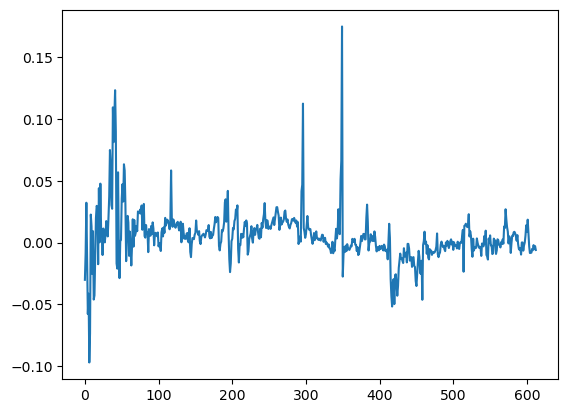

In [11]:
spread.prInc.plot()

<Axes: >

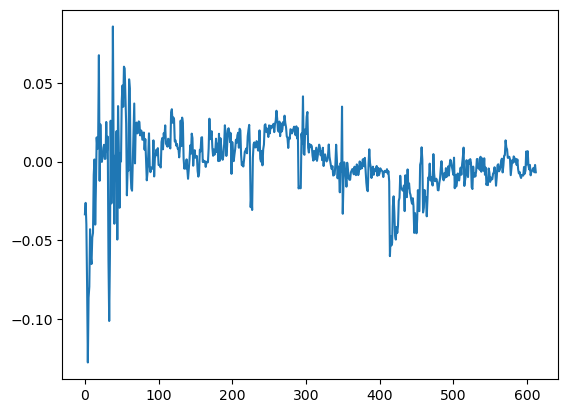

In [12]:
spread.prDec.plot()

# Helper Functions for Spread data Fetching

In [13]:
quandl.ApiConfig.api_key = 'NrLR6iDUF3zksCBL5eDQ'

In [14]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [15]:
@functools.lru_cache(maxsize=16)
def get_processed_data( tickers):
    security1 = tickers[0]
    security2 = tickers[1]
    
    rawdata_security1 = fetch_etf_data_quadl(security1 ,'2010-01-15','2024-01-10')
    rawdata_security2 = fetch_etf_data_quadl(security2 ,'2010-01-15','2024-01-10')

    rawdata_combined = pd.concat([rawdata_security1, rawdata_security2]).sort_values(['ticker','date']).reset_index(drop=True)

    rawdata_combined['adj_typical_price'] = (rawdata_combined['adj_high'] +  
                                             rawdata_combined['adj_low'] + rawdata_combined['adj_close']) / 3

    rawdata_combined['adj_dollar_vol'] = rawdata_combined['adj_volume'] * rawdata_combined['adj_close']

    rawdata_combined['adj_rolling_dollar_vol'] = rawdata_combined.groupby('ticker')['adj_dollar_vol'].rolling(15).median().reset_index(drop=True)
    
    return rawdata_combined

In [16]:
rawdata_combined = get_processed_data(tickers)

In [17]:
# rawdata_combined = rawdata_combined.set_index('date')
rawdata_combined 

,ticker,date,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,adj_typical_price,adj_dollar_vol,adj_rolling_dollar_vol
0,BAC,2010-01-15,16.64,16.6500,16.23,16.26,195117100.0,0.0,1.0,13.548581,13.556723,13.214751,13.239178,195117100.0,13.336884,2.583190e+09,NaN
1,BAC,2010-01-19,16.06,16.4700,15.84,16.32,181616500.0,0.0,1.0,13.076334,13.410164,12.897207,13.288031,181616500.0,13.198467,2.413326e+09,NaN
2,BAC,2010-01-20,16.22,16.6300,16.18,16.49,288741100.0,0.0,1.0,13.206609,13.540439,13.174041,13.426448,288741100.0,13.380309,3.876767e+09,NaN
3,BAC,2010-01-21,16.46,16.6600,15.20,15.47,551285500.0,0.0,1.0,13.402022,13.564865,12.376107,12.595946,551285500.0,12.845639,6.943962e+09,NaN
4,BAC,2010-01-22,15.26,15.5200,14.71,14.90,369620800.0,0.0,1.0,12.424960,12.636657,11.977141,12.131842,369620800.0,12.248547,4.484181e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,C,2024-01-04,53.92,54.7474,53.66,53.77,22515082.0,0.0,1.0,53.410323,54.229902,53.152780,53.261741,22515082.0,53.548141,1.199192e+09,8.677539e+08
7036,C,2024-01-05,54.03,54.6700,53.89,54.33,16856047.0,0.0,1.0,53.519283,54.153233,53.380606,53.816447,16856047.0,53.783429,9.071326e+08,8.677539e+08
7037,C,2024-01-08,53.99,54.0900,53.02,54.01,17181918.0,0.0,1.0,53.479661,53.578716,52.518830,53.499472,17181918.0,53.199006,9.192235e+08,8.677539e+08
7038,C,2024-01-09,53.85,53.9100,53.27,53.48,17151601.0,0.0,1.0,53.340984,53.400417,52.766467,52.974482,17151601.0,53.047122,9.085972e+08,8.677539e+08


In [18]:
rawdata_combined_processed = rawdata_combined.sort_values(['ticker','date'])
rawdata_combined_processed = rawdata_combined_processed.set_index(['date'])

rawdata_combined_processed = rawdata_combined_processed.groupby('ticker', as_index=False)[['adj_close', 'adj_volume']].shift()#.dropna()#.reset_index()
rawdata_combined_processed['ticker'] = rawdata_combined.set_index('date').ticker
rawdata_combined_processed

,adj_close,adj_volume,ticker
date,,,
2010-01-15,NaN,NaN,BAC
2010-01-19,13.239178,195117100.0,BAC
2010-01-20,13.288031,181616500.0,BAC
2010-01-21,13.426448,288741100.0,BAC
2010-01-22,12.595946,551285500.0,BAC
...,...,...,...
2024-01-04,53.132970,30341951.0,C
2024-01-05,53.261741,22515082.0,C
2024-01-08,53.816447,16856047.0,C


In [19]:
merged_data = mpd_stats.merge(rawdata_combined[['date','ticker', 'adj_close','adj_volume']], left_on=['idt','market'] , right_on=['date','ticker'])
merged_data

,market,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,date,ticker,adj_close,adj_volume
0,BAC,3.0,-0.02514,0.18210,-0.38173,0.85192,-0.25389,-0.01634,0.19272,-20.0,0.14898,20.0,0.09307,2010-01-15,BAC,13.239178,195117100.0
1,BAC,3.0,-0.02194,0.21265,-0.79513,1.61552,-0.28826,0.00001,0.21786,-20.0,0.16750,20.0,0.12009,2010-01-29,BAC,12.359823,175135300.0
2,BAC,3.0,-0.01699,0.21625,-0.86181,1.83248,-0.28670,0.00720,0.22358,-20.0,0.16404,20.0,0.12713,2010-02-12,BAC,11.765444,162819300.0
3,BAC,3.0,-0.00965,0.17893,-0.70108,1.40641,-0.23570,0.00776,0.19373,-20.0,0.12882,20.0,0.09233,2010-02-26,BAC,13.564865,343669400.0
4,BAC,3.0,0.00006,0.17357,-0.71889,1.63480,-0.21657,0.01649,0.19608,-20.0,0.11325,20.0,0.09545,2010-03-15,BAC,13.727947,120308200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1219,C,3.0,-0.00156,0.12235,-0.34116,0.91728,-0.15510,0.00443,0.14296,-20.0,0.05898,20.0,0.03996,2023-12-13,C,48.873615,21182611.0
1220,C,3.0,-0.00406,0.13064,-0.14578,0.79576,-0.16615,-0.00137,0.15344,-20.0,0.06728,20.0,0.05266,2023-12-20,C,49.596715,16821437.0
1221,C,3.0,-0.00230,0.12846,-0.30241,0.89189,-0.16268,0.00337,0.15010,-20.0,0.06524,20.0,0.04786,2023-12-27,C,50.973576,9844096.0
1222,C,3.0,-0.00257,0.13001,-0.23665,0.77179,-0.16456,0.00152,0.15372,-20.0,0.06614,20.0,0.05164,2024-01-03,C,53.132970,30341951.0


In [20]:
spread_cols = list(mpd_stats.columns) + ['date', 'adj_close', 'adj_volume']

merged_data_filtered = merged_data[spread_cols].set_index('date')
# merged_data_filtered
spreads_df = (merged_data_filtered[merged_data_filtered.market==security1].iloc[:,2:] - 
                        merged_data_filtered[merged_data_filtered.market==security2].iloc[:,2:])
spreads_df['norm_rolling_adj_close'] = (spreads_df.adj_close-spreads_df.adj_close.rolling(8).mean())/spreads_df.adj_close.rolling(8).std()
spreads_df['norm_rolling_prInc'] = (spreads_df.prInc-spreads_df.prInc.rolling(8).mean())/spreads_df.prInc.rolling(8).std()
spreads_df['norm_rolling_prDec'] = (spreads_df.prDec-spreads_df.prDec.rolling(8).mean())/spreads_df.prDec.rolling(8).std()

spreads_df

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
date,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,-0.03009,-13.708832,141099400.0,NaN,NaN,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,-0.00855,-13.800234,107192400.0,NaN,NaN,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,0.03234,-13.291478,143892400.0,NaN,NaN,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,-0.01294,-13.225555,325813700.0,NaN,NaN,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,-0.05782,-16.923444,56825300.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,-0.00612,-16.833615,36984538.0,-1.216512,-0.466302,-0.208431
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,-0.00199,-16.616715,27647540.0,-0.876313,0.414634,0.389341
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,-0.00524,-17.133576,14599441.0,-1.078636,0.211417,-0.683845


In [21]:
spreads_df[[ 'norm_rolling_adj_close', 'norm_rolling_prInc', 'norm_rolling_prDec']].corr()

,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec
norm_rolling_adj_close,1.000000,-0.014348,-0.088559
norm_rolling_prInc,-0.014348,1.000000,0.314974
norm_rolling_prDec,-0.088559,0.314974,1.000000


<Axes: xlabel='date'>

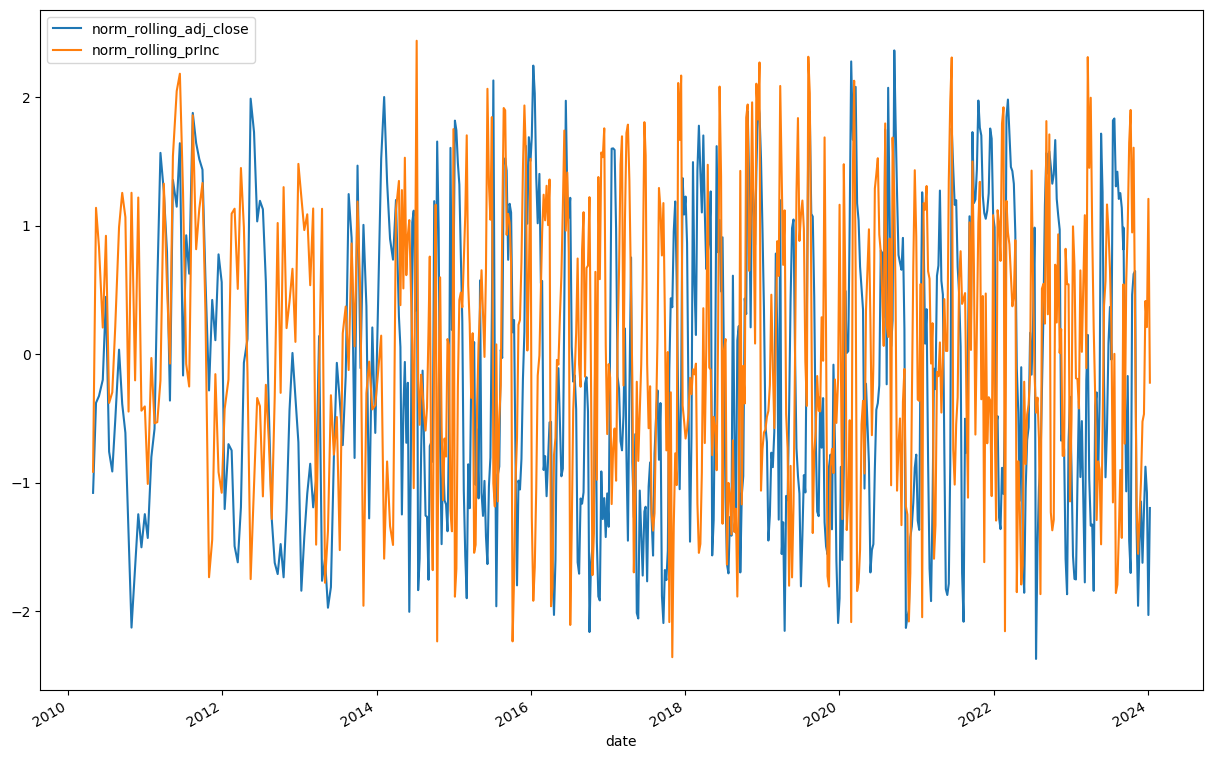

In [123]:
spreads_df[[ 'norm_rolling_adj_close', 'norm_rolling_prInc']].plot(figsize=(15,10))

In [23]:
BAC_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security1][['adj_close', 'adj_volume']]
BAC_data.columns = [security1, f'{security1}_adj_volume']
CITI_data = rawdata_combined_processed[rawdata_combined_processed.ticker==security2][['adj_close', 'adj_volume']]
CITI_data.columns = [security2, f'{security2}_adj_volume']
spreads_df_merged = spreads_df.merge(BAC_data, left_index=True, right_index=True)
spreads_df_merged = spreads_df_merged.merge(CITI_data, left_index=True, right_index=True)
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,adj_close,adj_volume,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume
date,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,-0.03009,-13.708832,141099400.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,-0.00855,-13.800234,107192400.0,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,0.03234,-13.291478,143892400.0,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,-0.01294,-13.225555,325813700.0,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,-0.05782,-16.923444,56825300.0,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,-0.00612,-16.833615,36984538.0,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,-0.00199,-16.616715,27647540.0,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,-0.00524,-17.133576,14599441.0,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0


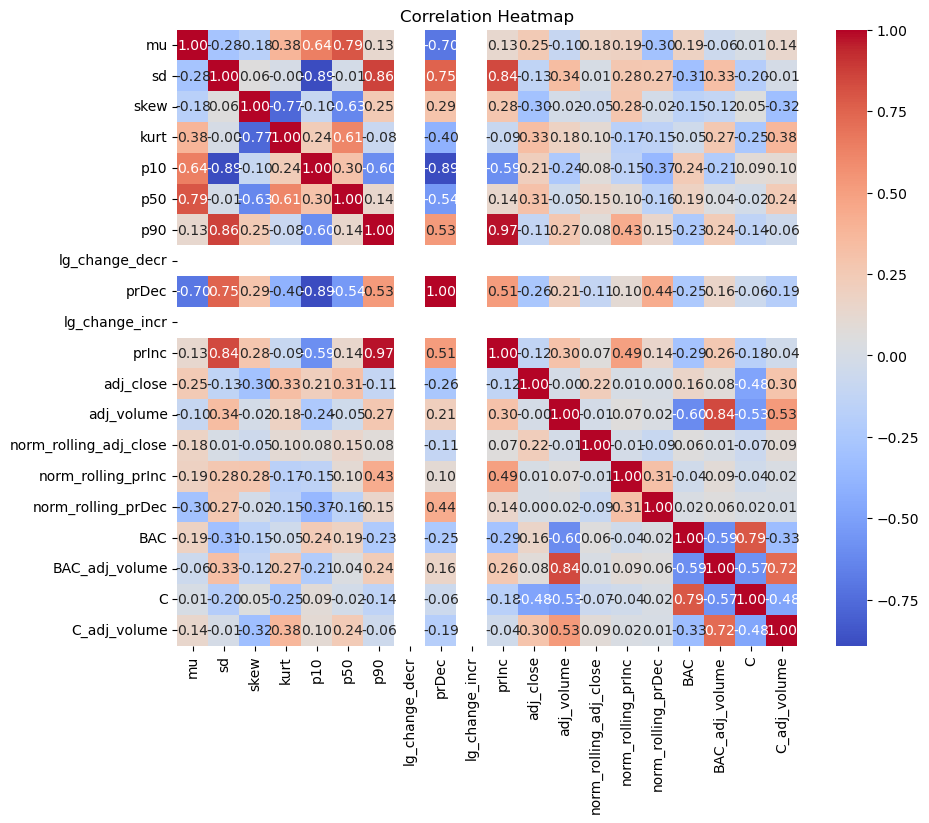

In [24]:
correlation_matrix = spreads_df_merged.corr()

# Creating a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

# Price Increase Probablity as spread

In [90]:
cap=1e9

In [203]:
spreads_df_merged['spread'] = spreads_df_merged['prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.03009,1.000000e+09,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0,-0.00855,1.000000e+09,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0,0.03234,1.000000e+09,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0,-0.01294,1.000000e+09,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0,-0.05782,1.000000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0,-0.00612,1.000000e+09,-1.216512
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0,-0.00199,1.000000e+09,-0.876313
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0,-0.00524,1.000000e+09,-1.078636


In [211]:

def tune_hyperparameter(spreads_df, K= 1e10, g=0.03, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g) 
        sell_condition = (spreads_df['spread'] < -g)
        
        if reverse:
            cond=sell_condition.copy()
            sell_condition = buy_condition.copy()
            buy_condition = cond.copy()

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if reverse:
            cond=sell_exit_cond.copy()
            sell_exit_cond = buy_exit_cond.copy()
            buy_exit_cond = cond.copy()
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        positions_df['month'] = positions_df.index.strftime('%Y-%m')
        positions_df['monthly_sl_not_hit'] = positions_df.groupby('month')['sl_not_hit'].cummin()
        sl_exits = positions_df['monthly_sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'dollars_available']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) / \
                          positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    return positions_pnl.total_pnl



In [212]:

# tune_hyperparameter(spreads_df_merged,K =1e10, g=0.03, j=0, s=-100, tc=0, interactive_plot=True)


In [213]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc,reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


In [214]:
# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# Strategy based on price decrease probablity

In [215]:
spreads_df_merged['spread'] = -spreads_df_merged['prDec']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03349,1.000000e+09,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0,0.02622,1.000000e+09,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0,0.03983,1.000000e+09,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0,0.07900,1.000000e+09,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0,0.12750,1.000000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0,0.00451,1.000000e+09,-1.216512
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0,0.00404,1.000000e+09,-0.876313
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0,0.00678,1.000000e+09,-1.078636


In [216]:
from ipywidgets import interactive

# Define your function that generates the plot based on parameters
def update_plot(K=1e10, g=0.03, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 0.05, num=501)
j_slider = np.linspace(0, 0.05, num=501)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=True)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

### We see that for the same set of parameters for a strategy, Price Increase porbablity and price decrease probablity lead to very different PnL.

## Strategy based on normalized probablities

In [217]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+09,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0,NaN,1.000000e+09,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0,NaN,1.000000e+09,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0,NaN,1.000000e+09,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0,NaN,1.000000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0,-0.466302,1.000000e+09,-1.216512
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0,0.414634,1.000000e+09,-0.876313
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0,0.211417,1.000000e+09,-1.078636


In [218]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(0, 5, num=501)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

In [151]:
spreads_df_merged['spread'] = -spreads_df_merged['norm_rolling_prDec']
spreads_df_merged['dollars_available'] = 1e9
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+09,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0,NaN,1.000000e+09,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0,NaN,1.000000e+09,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0,NaN,1.000000e+09,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0,NaN,1.000000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0,0.208431,1.000000e+09,-1.216512
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0,-0.389341,1.000000e+09,-0.876313
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0,0.683845,1.000000e+09,-1.078636


In [152]:

# signals reverse
def update_plot(K=1e10, g=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = tune_hyperparameter(spreads_df_merged,K, g, j, s, tc, reverse)


# Create sliders for varying features
# M_slider = range(5,100, 5) 
# k_slider = np.linspace(0, cap/20, num=101)
g_slider = np.linspace(0, 5, num=501)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-0.01, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

# Strategy based on using price and probability spreads

In [230]:

def two_spread_strat(spreads_df, K= 1e10, g=0.03, g2=0, j=0, s=-100, tc=0, reverse=False, interactive_plot=True):
    
    def get_raw_positions(spreads_df, sl_exit):
        spreads_df = spreads_df.copy()
        spreads_df['signal'] = np.nan

        buy_condition = (spreads_df['spread'] > g)  & (spreads_df['spread2'] < g2)
        sell_condition = (spreads_df['spread'] < -g) & (spreads_df['spread2'] > -g2)
        
        if reverse:
            cond=sell_condition.copy()
            sell_condition = buy_condition.copy()
            buy_condition = cond.copy()

        # Generate signals
        spreads_df.loc[buy_condition, 'signal'] = 1
        spreads_df.loc[sell_condition, 'signal'] = -1

        spreads_df['position'] = spreads_df['signal'].ffill()

        # Exit the position if the spread becomes flat (goes below j)
        sell_exit_cond = (spreads_df['position'] == -1) & (spreads_df['spread'] <= g) & (spreads_df['spread'] >= -j)
        buy_exit_cond = (spreads_df['position'] == 1) & (spreads_df['spread'] >= -g) & (spreads_df['spread'] <= j)
        
        if sl_exit is not None:
            spreads_df.loc[sl_exit, 'signal'] = 0

        # last day exit
        spreads_df['signal'].iloc[-1] = 0

        # normal exits
        spreads_df.loc[sell_exit_cond, 'signal'] = 0
        spreads_df.loc[buy_exit_cond, 'signal'] = 0
        spreads_df['position'] = spreads_df['signal'].ffill()

        # Create new_signal column representing changes in position
        spreads_df['final_signal'] = np.nan
        spreads_df['position'].fillna(0, inplace=True)

        spreads_df['new_position'] = 0
        spreads_df.loc[
            (spreads_df['position'].shift() != spreads_df['position']) & (
                        spreads_df['position'] != 0), 'new_position'] = 1
        spreads_df['position_count'] = spreads_df['new_position'].cumsum()

        spreads_df['final_signal'] = spreads_df['position'].diff()

        return spreads_df

    raw_positions = get_raw_positions(spreads_df, None)

    def process_positions(raw_positions):
        positions_df = raw_positions.copy()

        positions_df[security1 + '_' + 'quantity_held'] = np.nan
        positions_df[security2 + '_' + 'quantity_held'] = np.nan

        positions_df.loc[(positions_df.final_signal != 0), security1 + '_' + 'quantity_held'] = positions_df[
                                                                                                    'position'] * (
                                                                                                        positions_df[
                                                                                                            'dollars_available'] /
                                                                                                        positions_df[
                                                                                                            security1]).round()
        positions_df.loc[(positions_df.final_signal != 0), security2 + '_' + 'quantity_held'] = -1 * positions_df[
            'position'] * (positions_df['dollars_available'] / positions_df[security2]).round()

        positions_df[security1 + '_' + 'quantity_held'].ffill(inplace=True)
        positions_df[security2 + '_' + 'quantity_held'].ffill(inplace=True)

        positions_df['net_dollar_position'] = (
                    positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1] +
                    positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2])
        positions_df['gross_dollar_position'] = (
                (positions_df[security1 + '_' + 'quantity_held'] * positions_df[security1]).abs() +
                (positions_df[security2 + '_' + 'quantity_held'] * positions_df[security2]).abs())
        positions_df['net_dollar_position_change'] = (
                positions_df[security1 + '_' + 'quantity_held'].shift() * positions_df[security1].diff() +
                positions_df[security2 + '_' + 'quantity_held'].shift() * positions_df[security2].diff()).shift(-1)

        positions_df['transaction_cost'] = (
                                                   positions_df[security1 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security1] +
                                                   positions_df[security2 + '_' + 'quantity_held'].diff().abs() *
                                                   positions_df[security2]) * tc

        positions_df['position_pnl'] = positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum()

        positions_df['position_returns'] = (
                positions_df.groupby(['position_count'])['net_dollar_position_change'].cumsum() /
                positions_df.groupby('position_count')['gross_dollar_position'].transform('first'))

        return positions_df

    positions = process_positions(raw_positions)

    def implement_stop_loss(positions, sl_implemented):

        positions_df = positions.copy()

        positions_df['sl_not_hit'] = np.nan
        positions_df.loc[positions_df['new_position'] == 1, 'sl_not_hit'] = 1
        positions_df.loc[positions_df.groupby('position_count')['position_returns'].shift() <= s, 'sl_not_hit'] = 0
        positions_df['sl_not_hit'].ffill(inplace=True)
        positions_df['sl_not_hit'].fillna(1, inplace=True)

        positions_df['month'] = positions_df.index.strftime('%Y-%m')
        positions_df['monthly_sl_not_hit'] = positions_df.groupby('month')['sl_not_hit'].cummin()
        sl_exits = positions_df['monthly_sl_not_hit'] == 0

        if sl_implemented:
            return positions_df

        spreads_df = positions_df.loc[:, :'spread2']
        raw_positions = get_raw_positions(spreads_df, sl_exits)
        final_positions = process_positions(raw_positions)

        final_positions_sl = implement_stop_loss(final_positions, True)
        return final_positions_sl

    positions_sl_implemented = implement_stop_loss(positions, False)

    def calculate_and_plot_pnl(positions):

        positions = positions.copy()

        grouped_pnl_pct = (positions.groupby('position_count')['net_dollar_position_change'].sum() -
                           positions.groupby('position_count')['transaction_cost'].sum()) 
#         / \
#                           positions.groupby('position_count')['gross_dollar_position'].first()

        positions['total_pnl'] = positions['net_dollar_position_change'].cumsum() - positions[
            'transaction_cost'].cumsum()
        positions['cumulative_pnl'] = positions['total_pnl'] + K

        return grouped_pnl_pct, positions

    grouped_pnl_pct, positions_pnl = calculate_and_plot_pnl(positions_sl_implemented)

    plt.figure(figsize=(12, 8))
    positions_pnl.total_pnl.plot(color='blue', linewidth=2, label='Total PnL')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total PnL (USD)', fontsize=14)
    plt.title('Total PnL Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(fontsize=12)
    plt.show()

    cumulative_pnl = positions_pnl['cumulative_pnl'].dropna()
    cumulative_returns_percentage = ((cumulative_pnl / cumulative_pnl.iloc[0] - 1) * 100)
    cumulative_returns_percentage.plot(figsize=(12, 8), color='green', linewidth=2)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Cumulative Returns (%)', fontsize=14)
    plt.title('Cumulative Returns Over Time', fontsize=16)
    plt.grid(True, linestyle='--', alpha=0.6)

    if not interactive_plot:
        return grouped_pnl_pct, positions_pnl

    return positions_pnl.total_pnl



In [256]:
spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
spreads_df_merged['spread2'] = spreads_df_merged['norm_rolling_adj_close'].shift()
spreads_df_merged['dollars_available'] = cap
spreads_df_merged

,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,...,norm_rolling_adj_close,norm_rolling_prInc,norm_rolling_prDec,BAC,BAC_adj_volume,C,C_adj_volume,spread,dollars_available,spread2
date,,,,,,,,,,,,,,,,,,,,,
2010-01-15,0.00189,-0.03457,-0.25546,-0.44631,0.03525,0.00597,-0.03360,0.0,-0.03349,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+09,NaN
2010-01-29,0.00412,0.00649,-1.27900,0.76418,-0.01472,0.03981,-0.01788,0.0,-0.02622,0.0,...,NaN,NaN,NaN,12.514524,232729500.0,25.529694,51294200.0,NaN,1.000000e+09,NaN
2010-02-12,0.03706,-0.00687,-0.17752,0.17788,0.04614,0.03983,0.02996,0.0,-0.03983,0.0,...,NaN,NaN,NaN,11.912003,141086300.0,25.293308,23685200.0,NaN,1.000000e+09,NaN
2010-02-26,0.03606,-0.03662,-0.32420,0.54423,0.08628,0.03945,-0.01185,0.0,-0.07900,0.0,...,NaN,NaN,NaN,13.475301,287325100.0,26.711624,25996900.0,NaN,1.000000e+09,NaN
2010-03-15,0.03669,-0.06392,-0.67830,1.47369,0.12645,0.04897,-0.06483,0.0,-0.12750,0.0,...,NaN,NaN,NaN,13.727947,171456700.0,31.281755,127975900.0,NaN,1.000000e+09,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-13,0.00508,-0.00377,-0.21746,0.22243,0.00877,0.00835,-0.00231,0.0,-0.00451,0.0,...,-1.216512,-0.466302,-0.208431,30.740000,34192437.0,47.605714,14262734.0,-0.466302,1.000000e+09,-1.624739
2023-12-20,0.00487,-0.00256,-0.14740,-0.08384,0.00594,0.00736,0.00158,0.0,-0.00404,0.0,...,-0.876313,0.414634,0.389341,33.510000,44450349.0,50.448586,22728214.0,0.414634,1.000000e+09,-1.216512
2023-12-27,0.00399,-0.00496,-0.10368,0.02988,0.00892,0.00526,-0.00251,0.0,-0.00678,0.0,...,-1.078636,0.211417,-0.683845,33.860000,24638106.0,50.854710,11412901.0,0.211417,1.000000e+09,-0.876313


In [257]:
# Pr inc and Price thresholds
# signals reverse
def update_plot(K=1e10, g=0, g2=0, j=0, s=-100, tc = 0, reverse=False):

    positions_pnl = two_spread_strat(spreads_df_merged,K, g, g2, j, s, tc, reverse)


g_slider = np.linspace(0, 5, num=501)
g2_slider = np.linspace(-1, 5, num=601)
j_slider = np.linspace(-1, 5, num=601)
s_slider = np.linspace(-100, 0, num=101)
tc_slider = np.linspace(0, 0.00005, num=6)


# Create interactive plot
interactive_plot = interactive(update_plot,K=cap, g=g_slider, g2=g2_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
output = interactive_plot.children[-1]
interactive_plot

interactive(children=(FloatSlider(value=1000000000.0, description='K', max=3000000000.0, min=-1000000000.0), D…

In [258]:
# spreads_df_merged['spread'] = spreads_df_merged['norm_rolling_prInc']
# spreads_df_merged['spread2'] = spreads_df_merged['norm_rolling_adj_close']
# spreads_df_merged['dollars_available'] = cap
# spreads_df_merged

In [259]:

# def update_plot(K=1e10, g=0, g2=0, j=0, s=-100, tc = 0, reverse=False):

#     positions_pnl = two_spread_strat(spreads_df_merged,K, g, g2, j, s, tc, reverse)


# g_slider = np.linspace(0, 5, num=501)
# g2_slider = np.linspace(0, 5, num=501)
# j_slider = np.linspace(0, 5, num=601)
# s_slider = np.linspace(-100, 0, num=1001)
# tc_slider = np.linspace(0, 0.01, num=11)


# # Create interactive plot
# interactive_plot = interactive(update_plot,K=cap, g=g_slider, g2=g2_slider, j=j_slider, s=s_slider, tc = tc_slider, reverse=False)
# output = interactive_plot.children[-1]
# interactive_plot

In [260]:
def plot_signals(positions, upper_threshold, exit_threshold):
    """
    Plot spread with buy, sell, and exit signals, along with threshold boundaries.

    Parameters:
    - positions (pd.DataFrame): DataFrame containing spread and signal information.
    - upper_threshold (float): Upper threshold for buy signals.
    - exit_threshold (float): Threshold for exit signals.

    Returns:
    - None
    """

    # Create a DataFrame for threshold boundaries
    margin_boundary = pd.DataFrame(index=positions.index)
    margin_boundary["Upper Threshold (g)"] = upper_threshold
    margin_boundary["Lower Threshold (-g)"] = -upper_threshold
    margin_boundary["Exit Threshold (j)"] = exit_threshold
    margin_boundary["Exit Threshold (-j)"] = -exit_threshold

    # Plot spread over time
    fig, ax = plt.subplots(figsize=(20, 15))
    ax.plot(positions['spread2'], label='Spread')

    # Plot green dots for buy signals
    ax.plot(positions.loc[(positions["position"] == 1) & (positions["position"].shift() == 0)]['spread2'], '^', markersize=10, color='green', label='Buy Signal')

    # Plot red dots for short signals
    ax.plot(positions.loc[(positions["position"] == -1) & (positions["position"].shift() == 0)]['spread2'], 'v', markersize=10, color='red', label='Short Signal')

    # Plot blue dots for exit signals
    ax.plot(positions.loc[(positions["position"] == 0) & positions["position"].shift() != 0]['spread2'], 'o', markersize=5, color='blue', label='Exit Signal')

    # Plot Red dots for stop loss exit signals
    ax.plot(positions.loc[(positions["monthly_sl_not_hit"].diff().dropna() != 0) & 
                          (positions["final_signal"].isin([1, -1]))]['spread2'], 'o', markersize=10, 
            color='red', label='Stop Loss Exit Signal')

    
    # Plot threshold boundaries
    ax.plot(margin_boundary['Upper Threshold (g)'], color='red', label='Sell Threshold')
    ax.plot(margin_boundary['Lower Threshold (-g)'], color='green', label='Buy Threshold')
    ax.plot(margin_boundary['Exit Threshold (j)'], color='red', linestyle='--', label='Sell Exit Threshold')
    ax.plot(margin_boundary['Exit Threshold (-j)'], color='green', linestyle='--', label='Buy Exit Threshold')


    # Customize plot appearance
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel('Spread', fontsize=14)
    ax.set_title('Spread with Buy/Sell/Exit Signals and Thresholds', fontsize=16)
    ax.legend(fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

    # Show the plot
    plt.show()


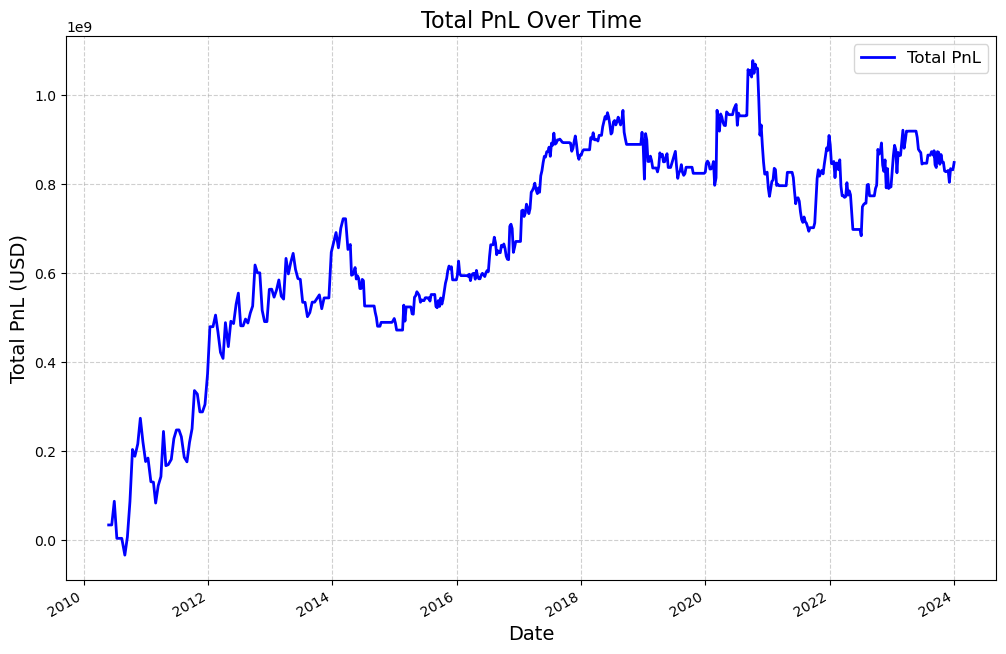

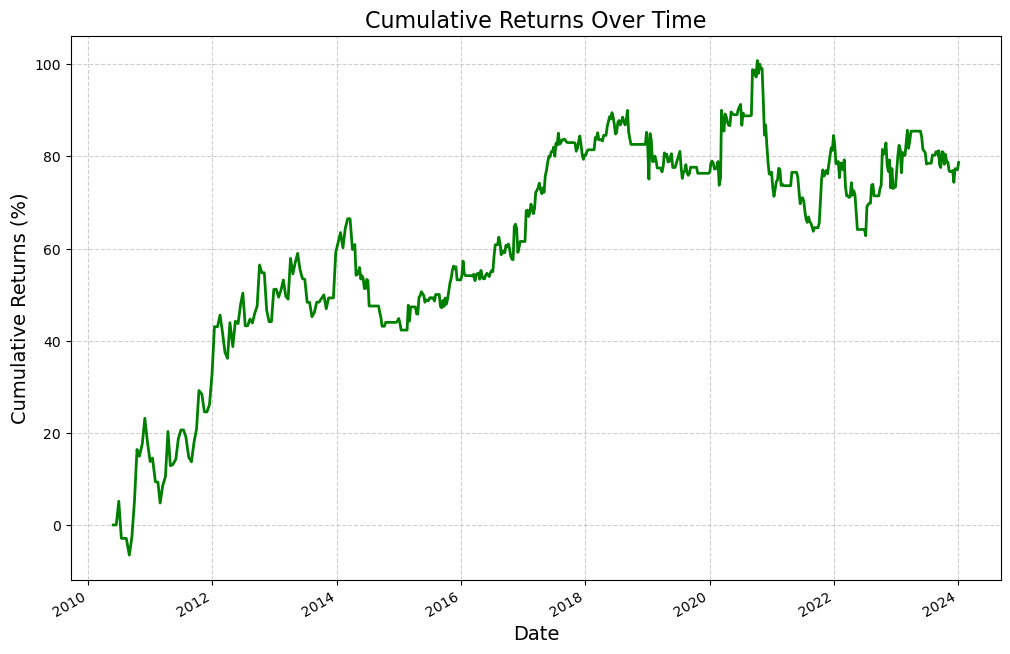

In [261]:
gp, positions_pnl = two_spread_strat(spreads_df_merged, K= cap, g=0.3, g2=0, j=0, s=-100, tc=0, reverse=True, interactive_plot=False)


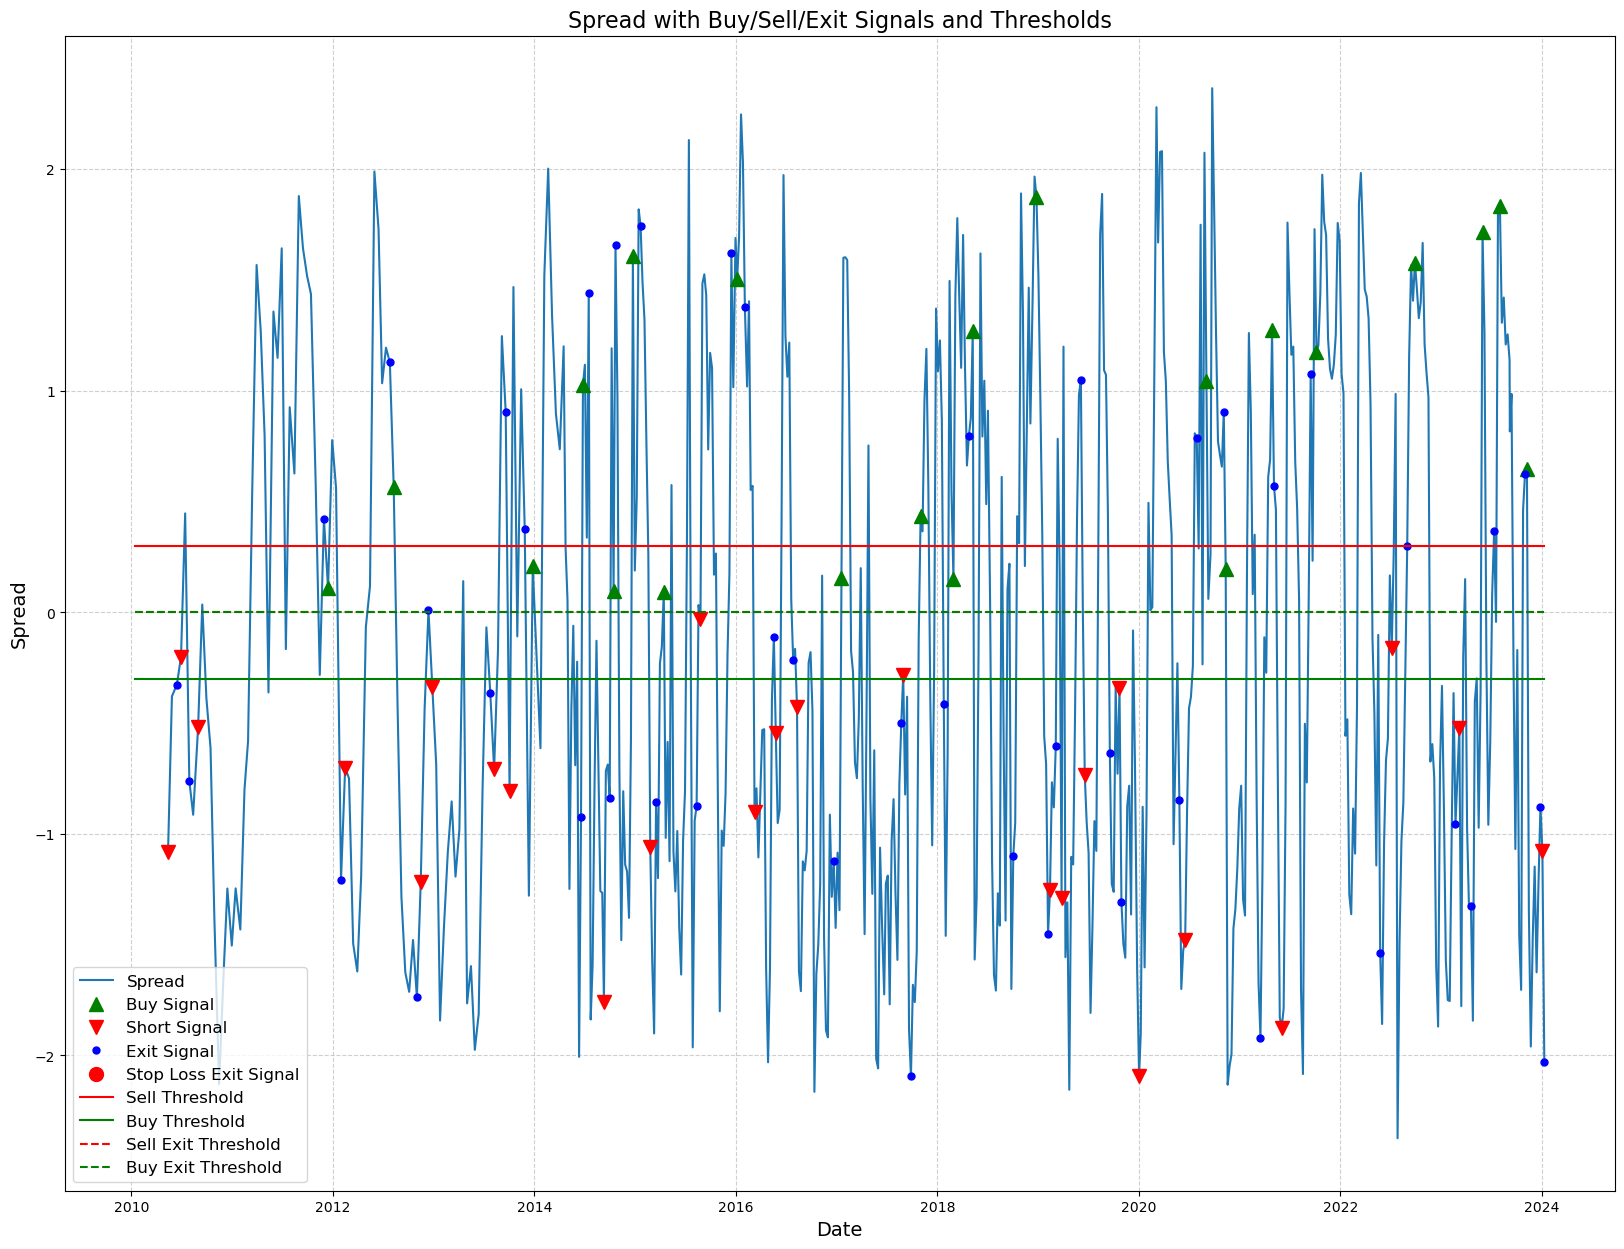

In [262]:
plot_signals(positions_pnl, 0.3, 0)

In [302]:
daily_start_ret = (positions_pnl.total_pnl.diff() / cap).to_frame('strat_returns').dropna()
daily_start_ret

,strat_returns
date,
2010-06-15,0.000000
2010-06-30,0.053189
2010-07-15,-0.083281
2010-07-30,0.000000
2010-08-13,0.000000
...,...
2023-12-06,-0.026685
2023-12-13,0.030742
2023-12-20,-0.002394


In [263]:
#hit rate
len(gp[gp>0])/len(gp)

0.5125

In [264]:
gp

position_count
0     0.000000e+00
1     3.462456e+07
2     5.318873e+07
3    -8.328091e+07
4     3.319967e+08
          ...     
75   -3.591148e+06
76    5.886006e+06
77   -1.442233e+07
78   -2.394378e+06
79    1.626023e+07
Length: 80, dtype: float64

In [265]:
positions_pnl.iloc[:,20:27]

,spread,dollars_available,spread2,signal,position,final_signal,new_position
date,,,,,,,
2010-01-15,NaN,1.000000e+09,NaN,NaN,0.0,NaN,0
2010-01-29,NaN,1.000000e+09,NaN,NaN,0.0,0.0,0
2010-02-12,NaN,1.000000e+09,NaN,NaN,0.0,0.0,0
2010-02-26,NaN,1.000000e+09,NaN,NaN,0.0,0.0,0
2010-03-15,NaN,1.000000e+09,NaN,NaN,0.0,0.0,0
...,...,...,...,...,...,...,...
2023-12-13,-0.466302,1.000000e+09,-1.624739,NaN,1.0,0.0,0
2023-12-20,0.414634,1.000000e+09,-1.216512,-1.0,-1.0,-2.0,1
2023-12-27,0.211417,1.000000e+09,-0.876313,0.0,0.0,1.0,0


In [269]:
# spy ret

In [ ]:
@functools.lru_cache(maxsize=16)
def fetch_etf_data_quadl(ticker,start_date,end_date):
    return quandl.get_table('QUOTEMEDIA/PRICES', date = {'gte':start_date,'lte': end_date}, ticker=ticker)

In [309]:
spy_data = fetch_etf_data_quadl('SPY', '2010-01-15','2024-01-10')

In [310]:
spy_data = spy_data.set_index('date')
spy_data['spy_adj_close'] = spy_data.adj_close.replace(np.inf, np.nan)
spy_data

,ticker,open,high,low,close,volume,dividend,split,adj_open,adj_high,adj_low,adj_close,adj_volume,returns,spy_returns,spy_adj_close
date,,,,,,,,,,,,,,,,
2024-01-10,SPY,474.160000,477.448100,473.870000,476.560000,66379545.0,0.0,1.0,474.160000,477.448100,473.870000,476.560000,66379545.0,NaN,NaN,476.560000
2024-01-09,SPY,471.870000,474.930000,471.350000,473.880000,65497238.0,0.0,1.0,471.870000,474.930000,471.350000,473.880000,65497238.0,-0.005624,-0.005624,473.880000
2024-01-08,SPY,468.430000,474.750000,468.300000,474.600000,74232526.0,0.0,1.0,468.430000,474.750000,468.300000,474.600000,74232526.0,0.001519,0.001519,474.600000
2024-01-05,SPY,467.490000,470.440000,466.430000,467.920000,85713902.0,0.0,1.0,467.490000,470.440000,466.430000,467.920000,85713902.0,-0.014075,-0.014075,467.920000
2024-01-04,SPY,468.300000,470.960000,467.050000,467.280000,83250038.0,0.0,1.0,468.300000,470.960000,467.050000,467.280000,83250038.0,-0.001368,-0.001368,467.280000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-01-22,SPY,111.199997,111.739998,109.089996,109.209999,345942400.0,0.0,1.0,85.421849,85.836668,83.800984,83.893168,345942400.0,-0.005102,-0.005102,83.893168
2010-01-21,SPY,113.919998,114.269997,111.559998,111.699997,344859600.0,0.0,1.0,87.511305,87.780168,85.698395,85.805940,344859600.0,0.022800,0.022800,85.805940
2010-01-20,SPY,114.279999,114.449997,112.980003,113.889999,216490200.0,0.0,1.0,87.787851,87.918440,86.789217,87.488260,216490200.0,0.019606,0.019606,87.488260


In [311]:
merged_ret_df = daily_start_ret.merge(spy_data[['spy_adj_close']], left_index=True, right_index=True)
merged_ret_df['spy_returns'] = merged_ret_df['spy_adj_close'].pct_change()
merged_ret_df = merged_ret_df.replace(np.inf,np.nan)
merged_ret_df = merged_ret_df.dropna()
merged_ret_df

,strat_returns,spy_adj_close,spy_returns
date,,,
2010-06-30,0.053189,79.998343,-0.074013
2010-07-15,-0.083281,85.005020,0.062585
2010-07-30,0.000000,85.462284,0.005379
2010-08-13,0.000000,83.943231,-0.017775
2010-08-31,-0.037661,81.618148,-0.027698
...,...,...,...
2023-12-06,-0.026685,452.920570,0.000330
2023-12-13,0.030742,468.596904,0.034612
2023-12-20,-0.002394,468.260000,-0.000719


In [312]:
merged_ret_df.corr()

,strat_returns,spy_adj_close,spy_returns
strat_returns,1.000000,-0.067382,-0.035761
spy_adj_close,-0.067382,1.000000,-0.008861
spy_returns,-0.035761,-0.008861,1.000000


In [313]:
X = merged_ret_df[['spy_returns']]
X = sm.add_constant(X)
model = sm.OLS(X,merged_ret_df[['strat_returns']])

results = model.fit()
results.params


,0,1
strat_returns,1.947567,-0.025091
